In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import arviz as az
import statsmodels.formula.api as smf
import pymc as pm
import bambi as bmb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import attila_utils

In [2]:
treatments = {
    'A': 'Amiloride',
    'B': 'HCQ',
    'C': 'HCQ nano',
    'D': 'Saline',
    'E': 'R-HCQ',
    'F': 'S-HCQ',
    'G': 'TUDCA',
    'H': 'Saline WT',
    'I': 'TUDCA WT',
    'J': 'DMSO WT',
}

In [3]:
fpath = '../../resources/QPS/5xFAD-mouse/CO28152_NFL-GFAP_datasum.xlsx'
dataw = pd.read_excel(fpath, sheet_name='NFL in vivo clean')
dataw['IRN'] = dataw.IRN.astype('str')
dataw['Treatment'] = dataw.Group.apply(lambda x: treatments[x])
dataw['Sex'] = pd.Categorical(dataw.Sex, categories=['m', 'f'], ordered=True)

value_vars = [x for x in dataw.columns if re.match('^NF-L week \d+$', x)]
id_vars = [x for x in dataw.columns if not re.match('^NF-L week \d+$', x)]

df = dataw[value_vars].apply(lambda r: r - r.loc['NF-L week 0'], axis=1)
df = df.rename({x: 'ΔNfl week ' + re.sub('NF-L week ', '', x) for x in df.columns}, axis=1)
df['max_ΔNfl'] = df.drop('ΔNfl week 0', axis=1).max(axis=1)

dataw = pd.concat([dataw, df], axis=1)

dataw = dataw.set_index('IRN')
df = pd.read_csv('../../resources/QPS/5xFAD-mouse/CO28152-animal-list.csv', index_col='IRN')
df['Lifespan (weeks)'] = df['Lifespan (days)'] / 7
dataw = pd.concat([dataw, df[['Curriculum vitae', 'Lifespan (days)']]], axis=1, join='inner')

dataw

,Cohort,Group,Sex,Genotype,NF-L week 0,NF-L week 4,NF-L week 8,NF-L week 12,Treatment,ΔNfl week 0,ΔNfl week 4,ΔNfl week 8,ΔNfl week 12,max_ΔNfl,Curriculum vitae,Lifespan (days)
IRN,,,,,,,,,,,,,,,,
15117,I,A,f,tg/wt,576.0,861.0,757.0,687.0,Amiloride,0.0,285.0,181.0,111.0,285.0,tissue sampling,326
15119,I,A,f,tg/wt,698.0,1042.0,783.0,644.0,Amiloride,0.0,344.0,85.0,-54.0,344.0,tissue sampling,322
14627 A,I,A,f,tg/wt,701.0,1085.0,677.0,763.0,Amiloride,0.0,384.0,-24.0,62.0,384.0,tissue sampling,325
15161,III,A,f,tg/wt,574.0,710.0,688.0,1028.0,Amiloride,0.0,136.0,114.0,454.0,454.0,tissue sampling,330
15938,II,A,m,tg/wt,291.0,559.0,377.0,438.0,Amiloride,0.0,268.0,86.0,147.0,268.0,tissue sampling,322
16122,IV,A,m,tg/wt,535.0,609.0,532.0,545.0,Amiloride,0.0,74.0,-3.0,10.0,74.0,tissue sampling,326
15127,I,B,f,tg/wt,621.0,739.0,664.0,733.0,HCQ,0.0,118.0,43.0,112.0,118.0,tissue sampling,322
15201,IV,B,f,tg/wt,370.0,375.0,638.0,550.0,HCQ,0.0,5.0,268.0,180.0,268.0,tissue sampling,324
15245,V,B,f,tg/wt,678.0,593.0,688.0,577.0,HCQ,0.0,-85.0,10.0,-101.0,10.0,tissue sampling,327


In [4]:
dataw['Curriculum vitae'].unique()

array(['tissue sampling'], dtype=object)

['named-figure/scatter-vs-max_ΔNfl-lifespan.png',
 'named-figure/scatter-vs-max_ΔNfl-lifespan.pdf']

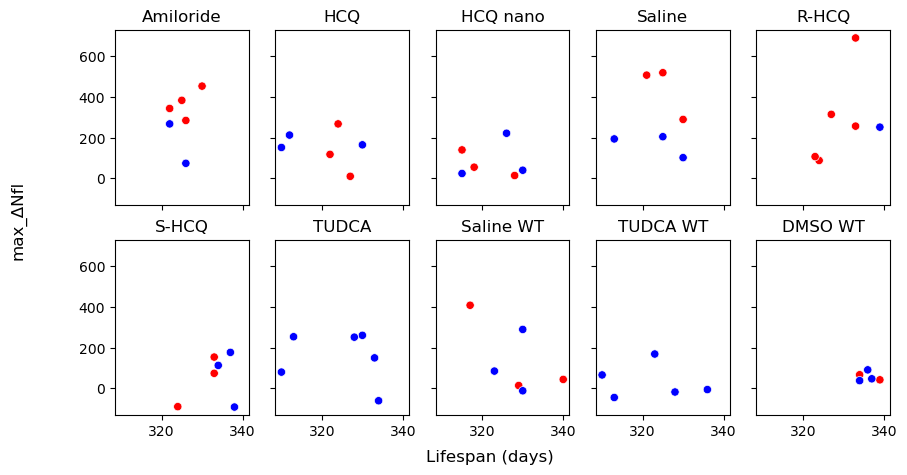

In [5]:
def my_scatter(x='Lifespan (days)', dataw=dataw):
    fig, ax = plt.subplots(2, 5, figsize=(10, 5), sharey=True, sharex=True)
    for t, axi in zip(treatments.values(), ax.ravel()):
        sns.scatterplot(data=dataw.loc[dataw.Treatment == t], y='max_ΔNfl', x=x, ax=axi, hue='Sex', palette=['blue', 'red'], legend=False)
        axi.set_title(t)
        axi.set_xlabel('')
        axi.set_ylabel('')
    
    fig.supxlabel(x)
    fig.supylabel('max_ΔNfl')
    return((fig, ax))

fig, ax = my_scatter(x='Lifespan (days)')
attila_utils.savefig(fig, 'scatter-vs-max_ΔNfl-lifespan')

['named-figure/scatter-max_ΔNfl-vs-Nfl-week-0.png',
 'named-figure/scatter-max_ΔNfl-vs-Nfl-week-0.pdf']

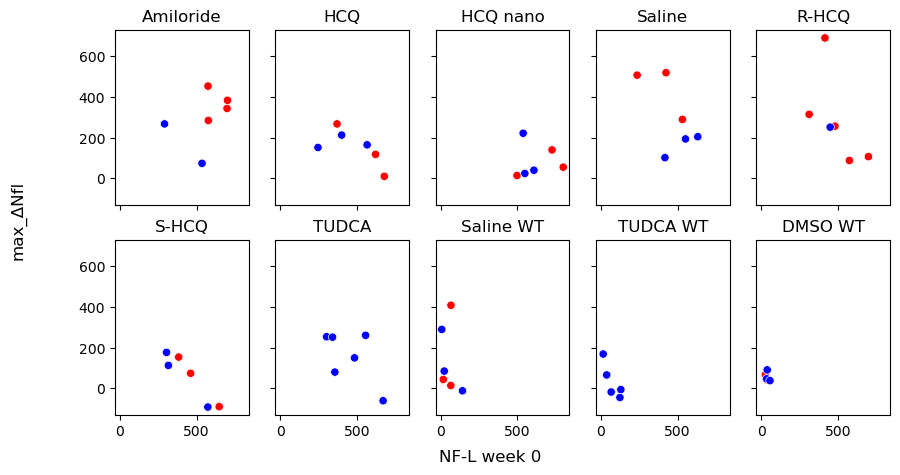

In [6]:
fig, ax = my_scatter(x='NF-L week 0')
attila_utils.savefig(fig, 'scatter-max_ΔNfl-vs-Nfl-week-0')

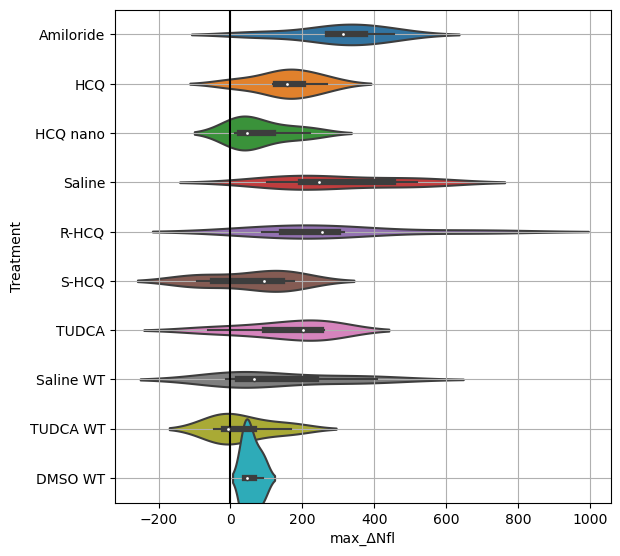

In [7]:
fig, ax = plt.subplots(figsize=(6.4, 6.4))
sns.violinplot(data=dataw, x='max_ΔNfl', y='Treatment', ax=ax, width=2.4)
ax.grid()
ax.axvline(0, color='black')

In [8]:
def subset_data(sel_treatments=['Saline', 'Saline WT', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA'], dataw=dataw):
    data = dataw.loc[dataw.Treatment.isin(sel_treatments)].copy()
    data['Treatment'] = pd.Categorical(data.Treatment, categories=sel_treatments, ordered=True)
    return(data)

In [9]:
model = bmb.Model('max_ΔNfl ~ 1 + Treatment', subset_data(sel_treatments=['Saline', 'Saline WT', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA']))
results = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [max_ΔNfl_sigma, Intercept, Treatment]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [10]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,299.225,60.976,178.682,406.022,1.539,1.088,1571.0,2233.0,1.0
Treatment[Saline WT],-160.569,83.574,-323.019,-8.870,1.803,1.278,2150.0,2763.0,1.0
Treatment[Amiloride],1.982,87.660,-153.333,174.881,1.875,1.326,2190.0,2804.0,1.0
Treatment[HCQ],-143.772,83.869,-303.321,10.313,1.744,1.235,2311.0,2791.0,1.0
Treatment[HCQ nano],-215.193,85.391,-375.550,-58.621,1.838,1.300,2161.0,2982.0,1.0
Treatment[R-HCQ],-13.594,86.649,-187.083,142.807,1.874,1.325,2134.0,2877.0,1.0
Treatment[S-HCQ],-243.879,86.040,-406.003,-84.132,1.899,1.343,2054.0,2607.0,1.0
Treatment[TUDCA],-142.543,85.861,-300.606,20.161,1.802,1.274,2276.0,2889.0,1.0
max_ΔNfl_sigma,148.623,16.639,121.270,182.637,0.293,0.209,3258.0,2860.0,1.0


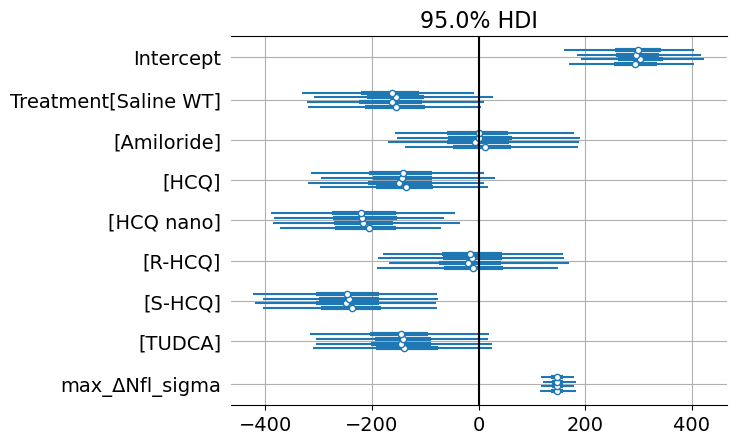

In [11]:
fig, ax = plt.subplots()
#az.plot_violin(results, ax=ax, hdi_prob=0.95)
az.plot_forest(results, ax=ax, hdi_prob=0.95)
ax.grid()
ax.axvline(0, color='black')

In [12]:
results_freq = smf.ols('max_ΔNfl ~ 1 + Treatment', data=subset_data(sel_treatments=['Saline', 'Saline WT', 'Amiloride', 'HCQ', 'HCQ nano', 'R-HCQ', 'S-HCQ', 'TUDCA'])).fit()
results_freq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               max_ΔNfl   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     2.781
Date:                Thu, 23 May 2024   Prob (F-statistic):             0.0187
Time:                        14:00:27   Log-Likelihood:                -302.76
No. Observations:                  48   AIC:                             621.5
Df Residuals:                      40   BIC:                             636.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                303.1667     59.379      5.106      0.000     183.157     423.177
Treatment[T.Saline WT]  -164.8333     83.975     -1.963      0.057    -334.553       4.887
Treatment[T.Amiloride]    -1.6667     83.975     -0.020      0.984    -171.387     168.053
Treatment[T.HCQ]        -148.8333     83.975     -1.772      0.084    -318.553      20.887
Treatment[T.HCQ nano]   -220.6667     83.975     -2.628      0.012    -390.387     -50.947
Treatment[T.R-HCQ]       -18.1667     83.975     -0.216      0.830    -187.887     151.553
Treatment[T.S-HCQ]      -247.1667     83.975     -2.943      0.005    -416.887     -77.447
Treatment[T.TUDCA]      -147.1667     83.975     -1.753      0.087    -316.887      22.553
==============================================================================
Omnibus:                        3.652   Durbin-Watson:                   2.145
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.654
Skew:                           0.544   Prob(JB):                        0.265
Kurtosis:                       3.377   Cond. No.                         8.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
%connect_info

{
  "shell_port": 58865,
  "iopub_port": 58866,
  "stdin_port": 58867,
  "control_port": 58869,
  "hb_port": 58868,
  "ip": "127.0.0.1",
  "key": "33eb301b-acd03ca5b517293705f9e0a8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/jonesa7/CTNS/notebooks/2024-05-20-nfl-modeling/2024-05-20-nfl-modeling.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-7593b891-7a8b-4903-8de8-1c692e035d3c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
